In [29]:
import astropy_healpix as ah
import healpy as hp
import numpy as np
from ligo.skymap import moc
from scipy.integrate import romb
from default_globals import *
from redshift_utils import z_cut, merger_rate, uniform_comoving_prior, redshift_pdf_given_lumdist_pdf, merger_rate_madau
from utils import gaussian
from numba import njit, prange
from scipy.interpolate import interp1d
from tqdm import tqdm
from ligo.skymap.io.fits import read_sky_map
import json
import matplotlib.pyplot as plt

import emcee
import corner
from multiprocessing import Pool, cpu_count

from utils import make_nice_plots
make_nice_plots()


In [48]:
def allsky_marginal_lumdist_distribution(dl_array, dP, norm, mu, sigma):
    '''Faster in mp for some reason'''
    dl_array = np.atleast_1d(dl_array)             # shape (M,)
    # Broadcast: (M,1) vs (N,)
    dl = dl_array[:, None]                         # (M,1)
    mu = mu[None, :]                               # (1,N)
    sigma = sigma[None, :]                         # (1,N)
    norm = norm[None, :]
    dP = dP[None, :]

    gauss = np.exp(-0.5 * ((dl - mu)/sigma)**2) / (sigma * np.sqrt(2*np.pi))
    result = np.sum(dP * norm * (dl**2) * gauss, axis=1)  # sum over N
    return result


def get_gw_z_posteriors(sky_map, z_integral_ax=np.linspace(1e-4, 10, 512+1), skymap_cl=0.999):

    sky_map = np.flipud(np.sort(sky_map, order="PROBDENSITY"))
    
    # Unpacking skymap
    dP_dA = sky_map["PROBDENSITY"]  # Probdens in 1/sr
    mu = sky_map["DISTMU"]          # Ansatz mean in Mpc
    sigma = sky_map["DISTSIGMA"]    # Ansatz width in Mpc
    norm = sky_map["DISTNORM"]      # Ansatz norm in 1/Mpc

    if np.sum(np.isnan(dP_dA)) > 0:
        print('BAD SKYMAP')
        return np.nan, np.nan, np.nan

    dA = moc.uniq2pixarea(sky_map["UNIQ"])  # Pixel areas in sr
    dP = dP_dA * dA  # Dimensionless probability density in each pixel
    cumprob = np.cumsum(dP)
    cumprob[cumprob > 1] = 1.  # Correcting floating point error which could cause issues when skymap_cl == 1
    pixprob_within_cl = (cumprob <= skymap_cl)
    skyprob_nonzero = (dP != 0)

    gw_redshift_posterior_marginalized = lambda z: redshift_pdf_given_lumdist_pdf(z, 
                                                                                    allsky_marginal_lumdist_distribution, 
                                                                                    dP=dP[skyprob_nonzero & pixprob_within_cl],
                                                                                    norm=norm[skyprob_nonzero & pixprob_within_cl], 
                                                                                    mu=mu[skyprob_nonzero & pixprob_within_cl], 
                                                                                    sigma=sigma[skyprob_nonzero & pixprob_within_cl])
    gw_redshift_posterior_marginalized_evaluated = gw_redshift_posterior_marginalized(z_integral_ax)
    
    return gw_redshift_posterior_marginalized_evaluated


In [130]:
SKYMAP_JSON_PATH = '/home/lucas/Documents/PhD/gw_data/real_skymaps.json'

ZTHRESH = 0.5

with open(SKYMAP_JSON_PATH, "r") as f:
    gw_path_dict = json.load(f)
gw_keys = list(gw_path_dict.keys())

print('Getting z posteriors...')
z_integral_ax = np.linspace(1e-4, 10, 512+1)
# ZPOSTERIORS = np.zeros( (len(gw_keys), len(z_integral_ax)) )
zposts = []
for i, key in tqdm( enumerate(gw_keys) ):

    filename = gw_path_dict[key]
    skymap = read_sky_map(filename, moc=True)

    post = get_gw_z_posteriors(skymap)
    zmax = z_integral_ax[np.argmax(post)]

    if zmax < ZTHRESH:
        # ZPOSTERIORS[i,:] = post
        zposts.append(post)

ZPOSTERIORS = np.array(zposts)
print(ZPOSTERIORS.shape)


Getting z posteriors...


168it [00:09, 17.37it/s]

(100, 513)


In [131]:
### do MCMC ###

truths = np.array([4.59, 2.86, 2.47])

gamma_prior = [0, 12]
k_prior = [0, 6]
zp_prior = [0, 4]
MCMC_PRIOR = np.array([gamma_prior, k_prior, zp_prior])
par_names = np.array(['gamma', 'k', 'zp'])
par_names_latex = np.array([r'$\gamma$', r'$k$', r'$z_{\rm p}$'])


def log_prior(theta):
    for i in range(0, len(theta)):
        if (theta[i] < MCMC_PRIOR[i, 0]) or (theta[i] > MCMC_PRIOR[i, 1]):
            return -np.inf
    return 0.0


def log10_likelihood_single_event(gw_z_posterior, ppop_z, PEprior, dz):
    llh = romb(y=gw_z_posterior / PEprior * ppop_z, dx=dz)
    return np.log10(llh)


def log_likelihood(theta):
    gamma, k, zp = theta

    ### Could be made globals ###
    z_integral_ax = np.linspace(1e-4, 10, 512+1)
    dz = np.diff(z_integral_ax)[0]
    unif_comvol = uniform_comoving_prior(z_integral_ax)
    PEprior = unif_comvol
    ########################

    ppop_z = unif_comvol * (1 + z_integral_ax)**gamma #merger_rate_madau(z_integral_ax, gamma, k, zp)
    ppop_z /= romb(ppop_z, dx=dz)

    total_log10_llh = 0
    for z_posterior in ZPOSTERIORS:
        total_log10_llh += log10_likelihood_single_event(z_posterior, ppop_z, PEprior, dz)
    
    selection_z_array = np.linspace(0, ZTHRESH, 512+1)
    ppop_interp = interp1d(z_integral_ax, ppop_z, bounds_error=False, fill_value=0)
    efficiency = romb(ppop_interp(selection_z_array), dx=np.diff(selection_z_array)[0])
    return total_log10_llh - ZPOSTERIORS.shape[0] * np.log10(efficiency)


def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)


ndim = 3
nwalkers = 200
nsteps = 10000

pos = np.random.normal(truths, 0.05, size=(nwalkers, ndim))
# pos[:, -1] = np.random.uniform(log10_lbk[0], log10_lbk[1], nwalkers)

with Pool(processes=cpu_count()) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool)
    sampler.run_mcmc(pos, nsteps, progress=True)


100%|██████████| 10000/10000 [03:42<00:00, 45.03it/s]


[0.474  0.4824 0.4797 0.4847 0.4919 0.4864 0.4834 0.4885 0.5014 0.472
 0.4728 0.468  0.4929 0.4857 0.4749 0.4865 0.4798 0.5037 0.4907 0.4786
 0.4652 0.491  0.4781 0.4837 0.4804 0.4981 0.4807 0.4941 0.4739 0.4531
 0.4956 0.4956 0.4764 0.485  0.4942 0.4834 0.4953 0.4657 0.4795 0.4768
 0.4877 0.5023 0.5045 0.4873 0.4676 0.4821 0.4931 0.4887 0.4899 0.4712
 0.4754 0.4824 0.4904 0.487  0.4717 0.4775 0.4972 0.4814 0.4944 0.4711
 0.4676 0.4783 0.4866 0.4762 0.4856 0.5114 0.4738 0.4907 0.4935 0.4788
 0.4934 0.4852 0.4782 0.4884 0.5021 0.4722 0.4769 0.4874 0.495  0.4988
 0.4862 0.4706 0.4878 0.4653 0.4935 0.477  0.4714 0.4843 0.4683 0.4972
 0.4973 0.4969 0.4831 0.4677 0.4822 0.4905 0.468  0.4793 0.4976 0.4749
 0.4696 0.4888 0.5116 0.4717 0.4905 0.4597 0.4799 0.4976 0.4942 0.4781
 0.4897 0.4882 0.5055 0.4841 0.4841 0.4838 0.4923 0.493  0.4925 0.4776
 0.4813 0.4716 0.4998 0.4877 0.4646 0.4908 0.4769 0.4709 0.4955 0.4808
 0.4893 0.4623 0.4874 0.4821 0.4928 0.475  0.5104 0.4943 0.4594 0.4831
 0.5035

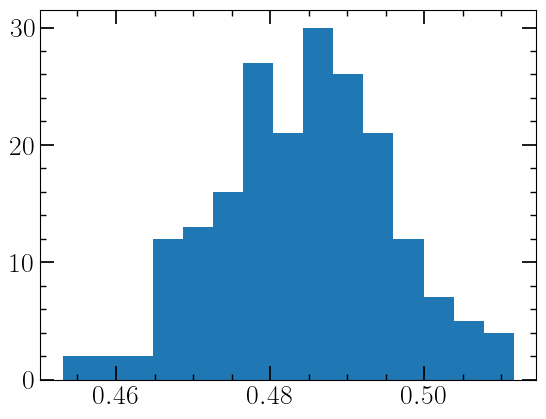

There are 200 good walkers.
lnL = -939.7 +/- 1.0


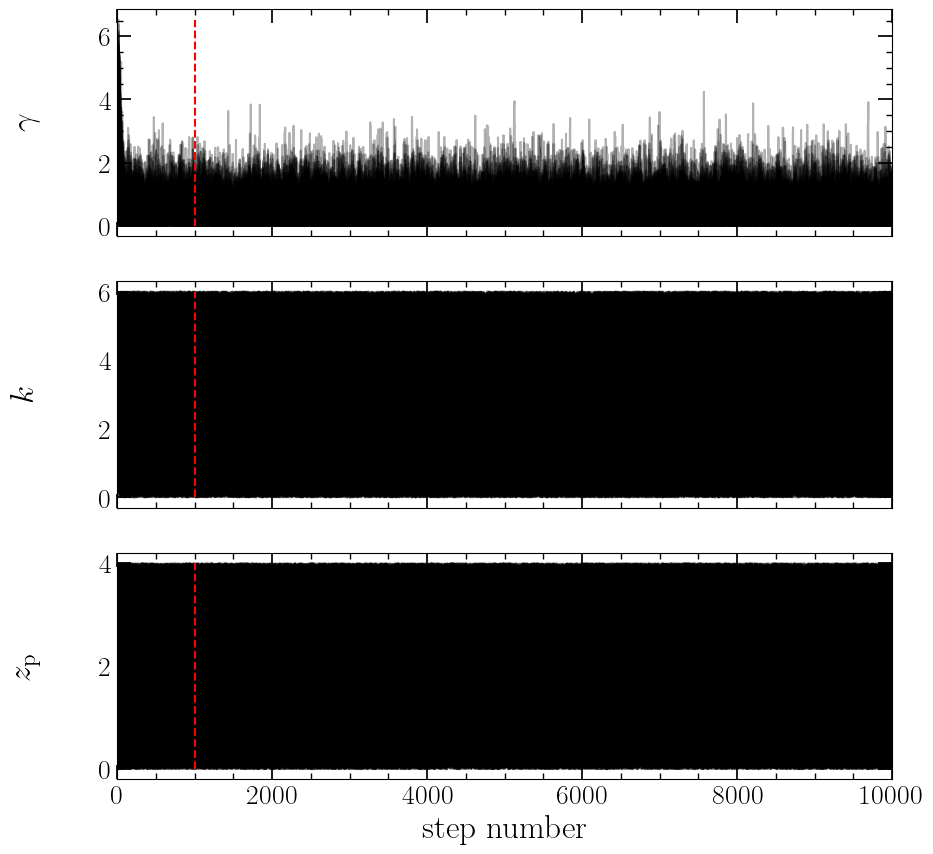

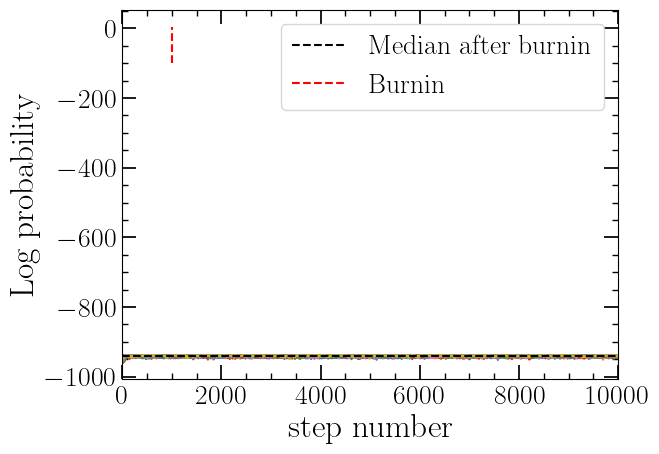

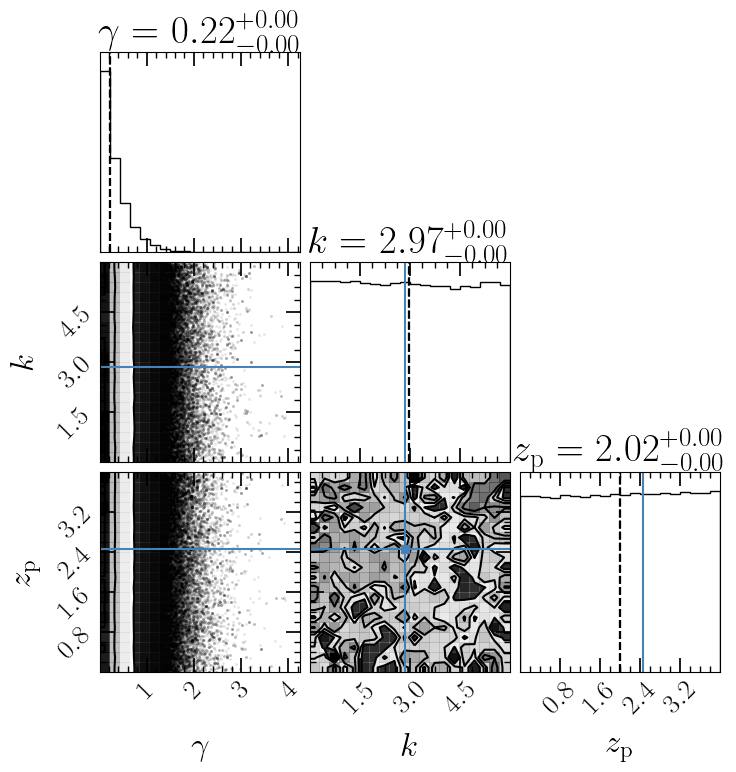

In [132]:
burnin = 1000
acceptance_fraction_low = 0.4
acceptance_fraction_high = 0.6

print(sampler.acceptance_fraction)
plt.figure()
plt.hist(sampler.acceptance_fraction, bins=15)
plt.show()

good_walkers = np.where((sampler.acceptance_fraction > acceptance_fraction_low) & (sampler.acceptance_fraction < acceptance_fraction_high))[0]
print(f'There are {len(good_walkers)} good walkers.')

samples = sampler.get_chain()
log_prob = sampler.get_log_prob()
median_log_prob = np.median(log_prob[burnin:, good_walkers])
print(f'lnL = {median_log_prob:.1f} +/- {np.std(log_prob[burnin:, good_walkers]):.1f}')

fname_string = ''
for name in par_names:
    fname_string += f'_{name}'
# np.save(os.path.join(DATA_DIR, f'mcmc_logprob{fname_string}_{PRIOR}prior_{LABEL}'), log_prob[burnin:, good_walkers])
# np.save(os.path.join(DATA_DIR, f'mcmc_samples{fname_string}_{PRIOR}prior_{LABEL}'), samples[burnin:, good_walkers, :])


fig, axes = plt.subplots(ndim, figsize=(10, 10), sharex=True)
for i in range(ndim):
    chains = samples[:, good_walkers, i]
    ax = axes[i]
    ax.plot(chains, "k", alpha=0.3)
    ax.vlines(burnin, np.min(chains), np.max(chains), linestyle='dashed', color='red')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(f'{par_names_latex[i]}')
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
# plt.savefig(os.path.join(PLOT_DIR, f'walkers{fname_string}_{PRIOR}prior_{LABEL}.pdf'), bbox_inches='tight')
# plt.close()


plt.figure()
for i in np.where(good_walkers)[0]:
    plt.plot(np.arange(nsteps), log_prob[:, i])
ymax = median_log_prob + np.abs(median_log_prob) * 1 + 5
# plt.ylim(-50, ymax)
plt.xlim(0, nsteps)
plt.hlines(median_log_prob, 0, nsteps, linestyle='dashed', color='black', label=f'Median after burnin')
plt.vlines(burnin, -100, ymax, linestyle='dashed', color='red', label='Burnin')
plt.xlabel('step number')
plt.ylabel('Log probability')
plt.legend()
# plt.savefig(os.path.join(PLOT_DIR, f'logprob{fname_string}_{PRIOR}prior_{LABEL}.pdf'), bbox_inches='tight')
# plt.close()

n_flat_samples = int(len(good_walkers) * (nsteps - burnin))
flat_samples = np.zeros((n_flat_samples, ndim))
for i in range(ndim):
    flat_samples[:, i] = samples[burnin:, good_walkers, i].flatten()
fig = corner.corner(
    flat_samples, 
    labels=[f'{par_names_latex[i]}' for i in range(ndim)],
    show_titles=True,
    truths=truths,
    quantiles=[0.5, 0.5, 0.5],
    title_fmt='.2f')
# plt.savefig(os.path.join(PLOT_DIR, f'corner{fname_string}_{PRIOR}prior_{LABEL}.pdf'), bbox_inches='tight')
# plt.close()


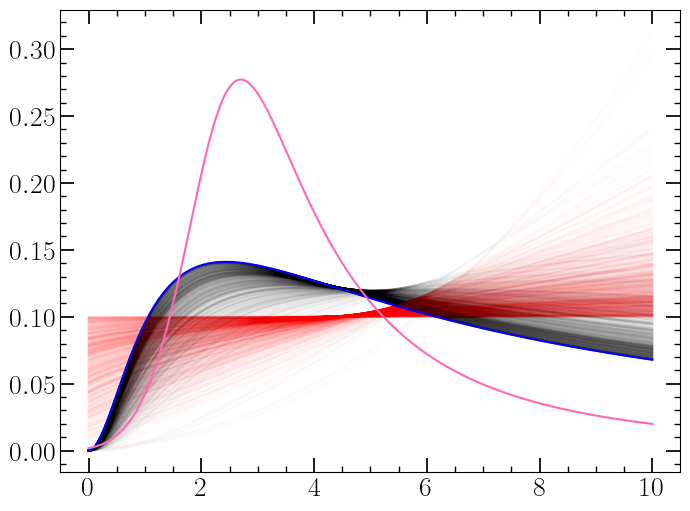

In [133]:
z_integral_ax = np.linspace(1e-4, 10, 512+1)
dz = np.diff(z_integral_ax)[0]
unif_comvol = uniform_comoving_prior(z_integral_ax)

plt.figure(figsize=(8,6))

N = int(1e3)
for i in range(N):
    idx = np.random.choice(np.arange(flat_samples.shape[0]))
    gamma, k, zp = flat_samples[idx,0], flat_samples[idx,1], flat_samples[idx,2]

    rate = (1 + z_integral_ax)**gamma  #merger_rate_madau(z_integral_ax, gamma, k, zp)

    ppop_z = unif_comvol * rate
    ppop_z /= romb(ppop_z, dx=dz)
    plt.plot(z_integral_ax, ppop_z, color='black', alpha=0.01)
    plt.plot(z_integral_ax, rate / romb(rate, dx=dz), color='red', alpha=0.01)

plt.plot(z_integral_ax, unif_comvol / romb(unif_comvol, dx=dz), color='blue')
plt.plot(z_integral_ax, merger_rate_madau(z_integral_ax, *np.array(truths)) / romb(merger_rate_madau(z_integral_ax, *np.array(truths)), dx=dz), color='hotpink')

# for i, zposterior in tqdm( enumerate(ZPOSTERIORS) ):
#     plt.plot(z_integral_ax, zposterior, alpha=0.3)

# plt.xlim(0, 2)
# plt.ylim(0, 0.01)
plt.show()


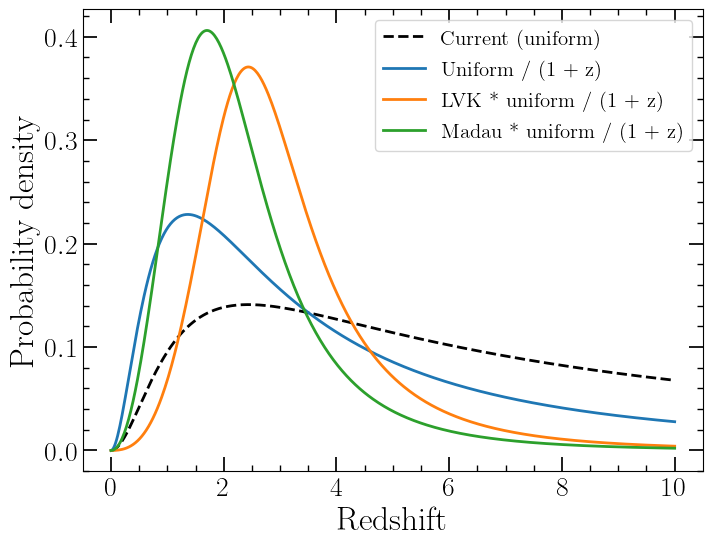

In [148]:
z_integral_ax = np.linspace(1e-4, 10, 512+1)
dz = np.diff(z_integral_ax)[0]
unif_comvol = uniform_comoving_prior(z_integral_ax)

def time_dilation(z):
    return 1 / (1 + z)

dilation = time_dilation(z_integral_ax)

def real_madau(z):
    b = 2.7
    c = 2.9
    d = 5.6
    return (1 + z)**b / (1 + ((1 + z) / c)**d)

plt.figure(figsize=(8,6))
plt.plot(z_integral_ax, unif_comvol / romb(unif_comvol, dx=dz), label='Current (uniform)', color='black', linewidth=2, linestyle='dashed')
plt.plot(z_integral_ax, dilation * unif_comvol / romb(dilation * unif_comvol, dx=dz), label='Uniform / (1 + z)', linewidth=2)
# plt.plot(z_integral_ax, dilation * merger_rate_madau(z_integral_ax) / romb(dilation * merger_rate_madau(z_integral_ax), dx=dz), label='LVK / (1 + z)', linestyle='dashed')
# plt.plot(z_integral_ax, dilation * real_madau(z_integral_ax) / romb(dilation * real_madau(z_integral_ax), dx=dz), label='Madau / (1 + z)', linestyle='dashed')
plt.plot(z_integral_ax, dilation * merger_rate_madau(z_integral_ax) * unif_comvol / romb(dilation * merger_rate_madau(z_integral_ax) * unif_comvol, dx=dz), label='LVK * uniform / (1 + z)', linewidth=2)
plt.plot(z_integral_ax, dilation * real_madau(z_integral_ax) * unif_comvol / romb(dilation * real_madau(z_integral_ax) * unif_comvol, dx=dz), label='Madau * uniform / (1 + z)', linewidth=2)
plt.legend(fontsize=15)
plt.ylabel('Probability density')
plt.xlabel('Redshift')
plt.show()
